In [2]:
# Run this cell
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

%matplotlib inline
import re
import nltk
import string
# run this in cmd to avoid an error beforehand for this import
# python -m nltk.downloader stopwords punkt
from nltk.corpus import stopwords

import random
from sklearn import linear_model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l1, l2

from sklearn.metrics import precision_score, recall_score

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if tf.config.experimental.list_physical_devices('GPU'):
    print("GPU is available.")
else:
    print("GPU is not available.")

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


Num GPUs Available:  0
GPU is not available.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prest\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\prest\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\prest\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
PUNCT_TO_REMOVE = string.punctuation
STOPWORDS = set(stopwords.words('english'))

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])


In [4]:
df = pd.read_csv('train.csv')
df["text"] = df["text"].str.lower()
df["text"] = df["text"].apply(lambda text: remove_urls(text))
df["text"] = df["text"].apply(lambda text: remove_punctuation(text))
df["text"] = df["text"].apply(lambda text: remove_stopwords(text))
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [5]:
def randNoun(lines):
    # function to test if something is a noun
    is_noun = lambda pos: pos[:2] == 'NN'
    # do the nlp stuff
    tokenized = nltk.word_tokenize(lines)
    nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
    if (len(nouns) == 0): # if no nouns picked up return rand word in text
        return lines[random.randrange(len(lines))]
    return nouns[random.randrange(len(nouns))]

In [6]:
# preprocessing of the dataset
print(len(df["location"]))
words = {} # will hold unique keywords
count = 0
# getting rid of %20 in keyword and getting a list of all the unqiue keywords
for i in df["keyword"]:
    i = str(i).replace("%20", ' ')
    if (i not in words.keys() and i != "nan"):
        words[i] = count
        count+=1

# filling in missing feature values
# missing keywords get filled in with a keywords already in "words" if that keyword shows up in text, otherwise pick a random word from text
# Missing "location" gets filled in with "Earth"
for i,j in df.iterrows():
    if (pd.isna(j["keyword"])):
        for k in words.keys():
            if k in j["text"]:
                df.at[i, "keyword"] = k
            else:
                df.at[i, "keyword"] = randNoun(j["text"])
    if (pd.isna(j["location"])):
        df.at[i, "location"] = "Earth"
# for i, j in df.iterrows():
#     if (pd.isna(j["location"])):
#         df.drop(i, axis=0, inplace=True)

print(len(df["text"]))


7613
7613


In [8]:
# we are going to feature transform 
corpus = df["text"].to_list() # combine all text to a bag of words
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus).toarray() # TF-IDF text encoding

#doing hot and cold encoding for keywords
words = {} # will hold unique keywords with a corresponding index
count = 0
for i in df["keyword"]:
    if (i not in words.keys()):
        words[i] = count
        count+=1
print(words)
keywords_hot_cold = np.zeros((len(df["keyword"]), len(words.keys()))) # init feature shape
for i in range(keywords_hot_cold.shape[0]):
    row = np.zeros(keywords_hot_cold.shape[1])
    row[words[df.at[i, "keyword"]]] = 1 # using the index found in the dict, index the row and set the corresponding value of the keyword to 1
    keywords_hot_cold[i] = row


#doing hot and cold encoding for locations
locations = {}
count = 0
for i in df["location"]:
    if (i not in locations.keys()):
        locations[i] = count
        count+=1
location_hot_cold = np.zeros((len(df["location"]), len(locations.keys())))
for i in range(location_hot_cold.shape[0]):
    row = np.zeros(location_hot_cold.shape[1])
    row[locations[df.at[i, "location"]]] = 1
    location_hot_cold[i] = row



# print(np.max(locations_vector))




{'deeds': 0, 'fire': 1, 'orders': 2, 'people': 3, 'smoke': 4, 'wildfires': 5, 'disaster': 6, 'top': 7, 'theres': 8, 'area': 9, 'gon': 10, 'days': 11, 'myanmar': 12, 'car': 13, 'whats': 14, 'fruits': 15, 'summer': 16, 'fast': 17, 'goooooooaaaaaal': 18, 'c': 19, 'cool': 20, 'love': 21, 'day': 22, 'looooool': 23, 'eat': 24, 'week': 25, 'girlfriend': 26, 'cooool': 27, 'pasta': 28, 'end': 29, 'ablaze': 30, 'accident': 31, 'aftershock': 32, 'airplane%20accident': 33, 'ambulance': 34, 'annihilated': 35, 'annihilation': 36, 'apocalypse': 37, 'armageddon': 38, 'army': 39, 'arson': 40, 'arsonist': 41, 'attack': 42, 'attacked': 43, 'avalanche': 44, 'battle': 45, 'bioterror': 46, 'bioterrorism': 47, 'blaze': 48, 'blazing': 49, 'bleeding': 50, 'blew%20up': 51, 'blight': 52, 'blizzard': 53, 'blood': 54, 'bloody': 55, 'blown%20up': 56, 'body%20bag': 57, 'body%20bagging': 58, 'body%20bags': 59, 'bomb': 60, 'bombed': 61, 'bombing': 62, 'bridge%20collapse': 63, 'buildings%20burning': 64, 'buildings%20on

In [9]:
# combine all features and split into training and validation sets

X = np.hstack((keywords_hot_cold, location_hot_cold, X))
# scalar = StandardScaler()
# scalar.fit(X)
# X = scalar.fit_transform(X)
# X = keywords_hot_cold
# X_train = X
# y_train = df["target"]
X = X**2
X_train, X_val,  y_train, y_val = train_test_split(X, df["target"], test_size=.4)

# X_train = scalar.fit_transform(X_train)
# X_val = scalar.fit_transform(X_val)

y_train = y_train.to_numpy()
y_val = y_val.to_numpy()


# poly = PolynomialFeatures(1)
# X_train = poly.fit_transform(X_train)
# X_val = poly.fit_transform(X_val)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(4567, 21328) (4567,) (3046, 21328) (3046,)


In [15]:
# NN Training is here
# This is everything that will be tried
number_of_text_features = vectorizer.get_feature_names_out().shape[0]  # This gets the number of output features from TF-IDF
number_of_keyword_features = len(words)  # This is how many unique keywords you have
number_of_location_features = len(locations)  # This is how many unique locations you have

total_features = number_of_text_features + number_of_keyword_features + number_of_location_features

print(f"Total number of features: {total_features}")
print(number_of_text_features)
print(number_of_keyword_features)
print(number_of_location_features)


# Define your lambda values, learning rates, and activations
lmdas = [0.00005, 0.00001, 0.000005, 0.000001, 0.0000005, 0.0000001]
learning_rates = [0.001]
activations = ['relu']
regularizations = [l1, l2]
transformations = ['none', 'square']

results = []

# Running experiments
for lr in learning_rates:
    for act in activations:
        for reg in regularizations:
            for lmda in lmdas:
                for transform in transformations:
                    print(f"Starting: LR={lr}, Act={act}, Reg={reg.__name__}, Lambda={lmda}, Transform={transform}")
                    model = Sequential([
                        Dense(512, activation=act, input_dim=total_features, kernel_regularizer=reg(lmda)),
                        Dense(256, activation=act, kernel_regularizer=reg(lmda)),
                        Dense(1, activation='sigmoid')
                    ])

                    optimizer = Adam(learning_rate=lr)
                    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

                    if transform == 'square':
                        X_train_transformed = X_train**2
                        X_val_transformed = X_val**2
                    else:
                        X_train_transformed = X_train
                        X_val_transformed = X_val

                    # Training the model
                    history = model.fit(X_train_transformed, y_train, epochs=10, batch_size=64, validation_data=(X_val_transformed, y_val), verbose=0)

                    # Evaluate model and make predictions
                    val_loss, val_accuracy = model.evaluate(X_val_transformed, y_val, verbose=0)
                    y_pred = (model.predict(X_val_transformed) > 0.5).astype(int)

                    # Calculate sum of absolute weights
                    total_weight_sum = sum(np.sum(np.abs(weights)) for weights in model.get_weights())

                    # Computing precision and recall
                    precision = precision_score(y_val, y_pred, zero_division=0)
                    recall = recall_score(y_val, y_pred, zero_division=0)

                    # Storing results
                    results.append({
                        'learning_rate': lr,
                        'activation': act,
                        'regularization': reg.__name__,
                        'lambda': lmda,
                        'transformation': transform,
                        'train_loss': history.history['loss'][-1],  # Last epoch training loss
                        'train_accuracy': history.history['accuracy'][-1],
                        'validation_accuracy': val_accuracy,
                        'validation_loss': val_loss,
                        'weight_sum': total_weight_sum,
                        'precision': precision,
                        'recall': recall
                    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df[['learning_rate', 'activation', 'regularization', 'lambda', 'transformation', 'train_loss', 'train_accuracy', 'validation_accuracy', 'weight_sum', 'precision', 'recall']])

Total number of features: 21328
17714
273
3341
Starting: LR=0.001, Act=relu, Reg=L1, Lambda=5e-05, Transform=none
96/96 [==============================] - 1s 6ms/step
Starting: LR=0.001, Act=relu, Reg=L1, Lambda=5e-05, Transform=square
96/96 [==============================] - 1s 9ms/step
Starting: LR=0.001, Act=relu, Reg=L1, Lambda=1e-05, Transform=none
96/96 [==============================] - 1s 7ms/step
Starting: LR=0.001, Act=relu, Reg=L1, Lambda=1e-05, Transform=square
96/96 [==============================] - 1s 9ms/step
Starting: LR=0.001, Act=relu, Reg=L1, Lambda=5e-06, Transform=none
96/96 [==============================] - 1s 7ms/step
Starting: LR=0.001, Act=relu, Reg=L1, Lambda=5e-06, Transform=square
96/96 [==============================] - 1s 9ms/step
Starting: LR=0.001, Act=relu, Reg=L1, Lambda=1e-06, Transform=none
96/96 [==============================] - 1s 6ms/step
Starting: LR=0.001, Act=relu, Reg=L1, Lambda=1e-06, Transform=square
96/96 [==============================]

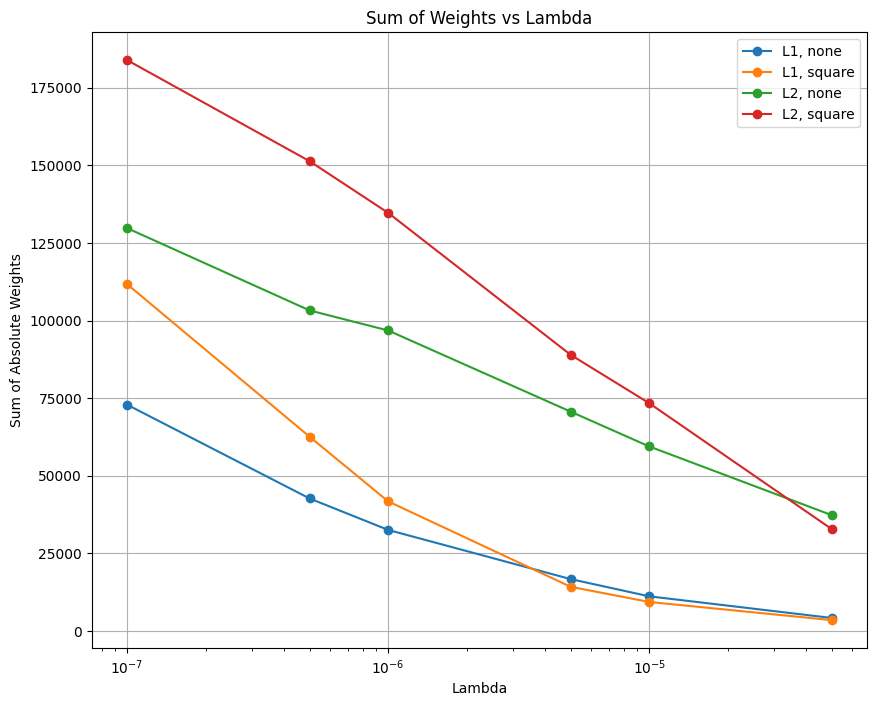

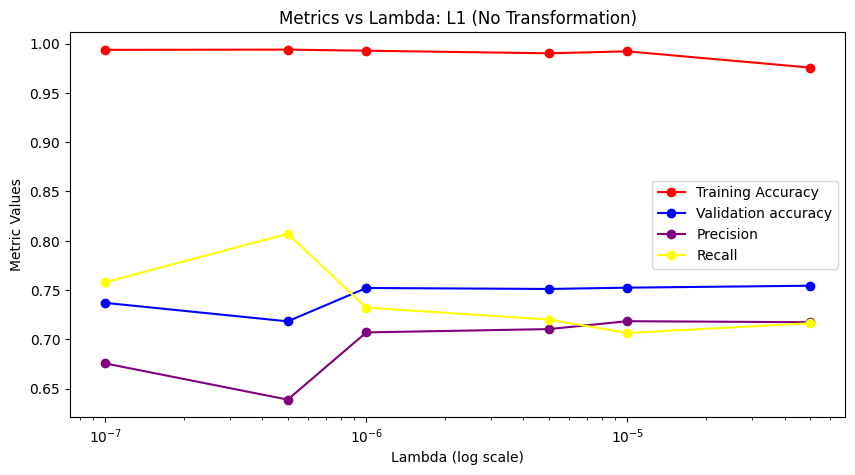

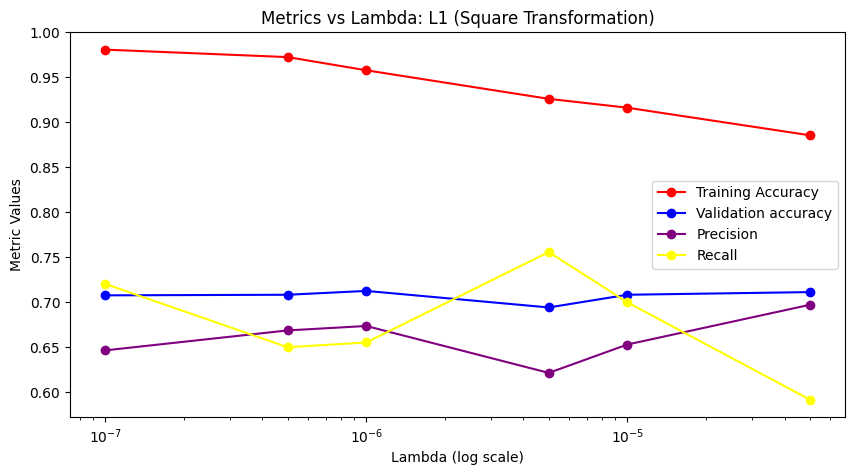

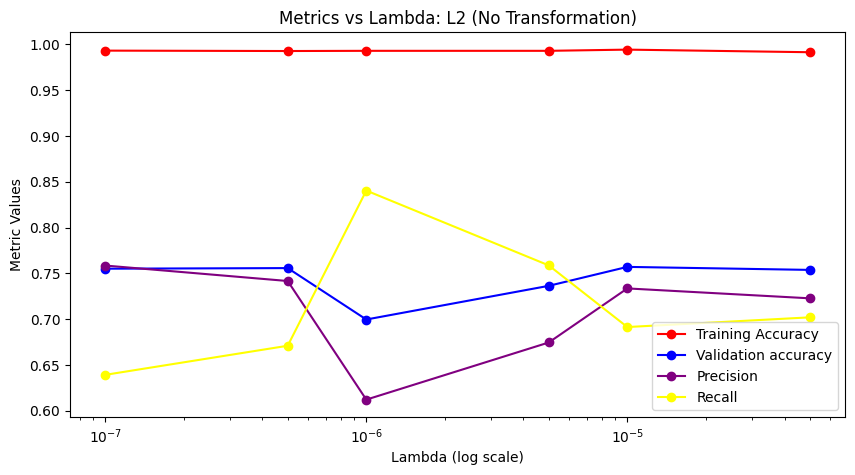

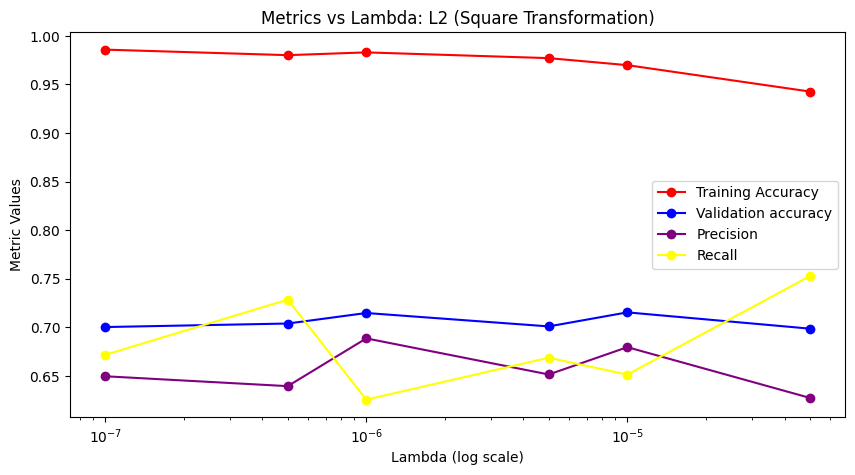

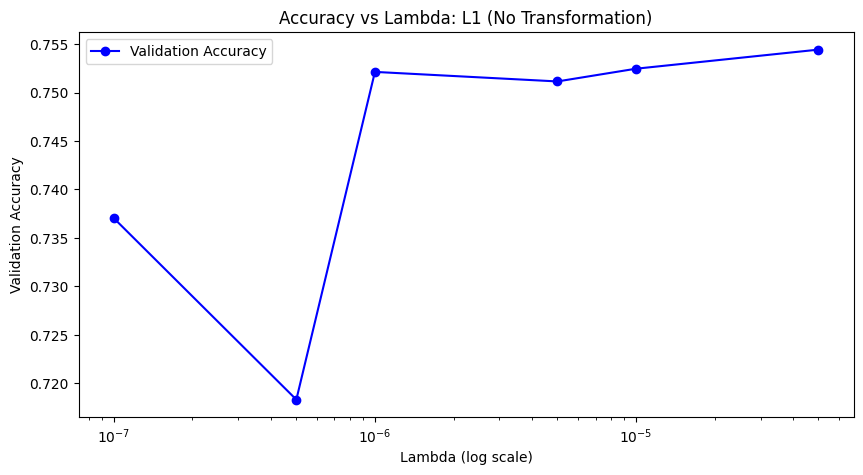

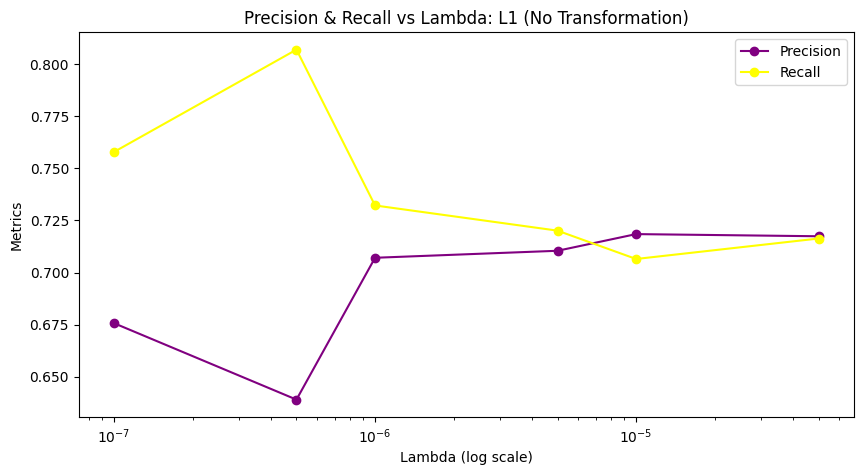

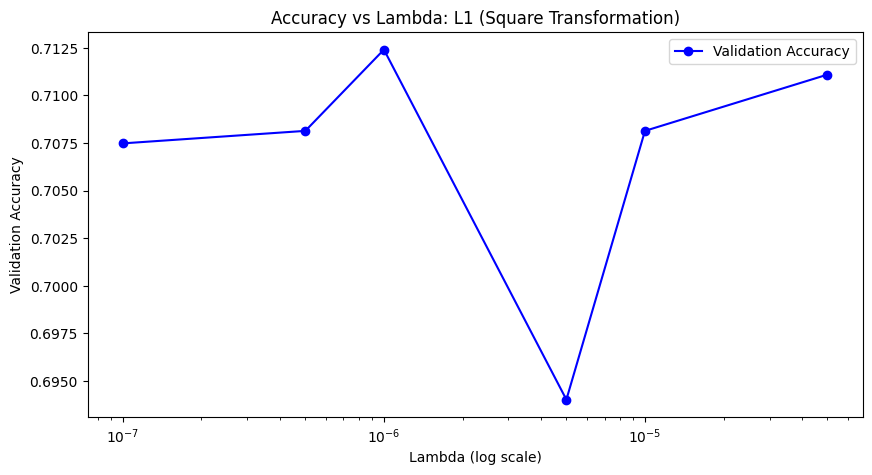

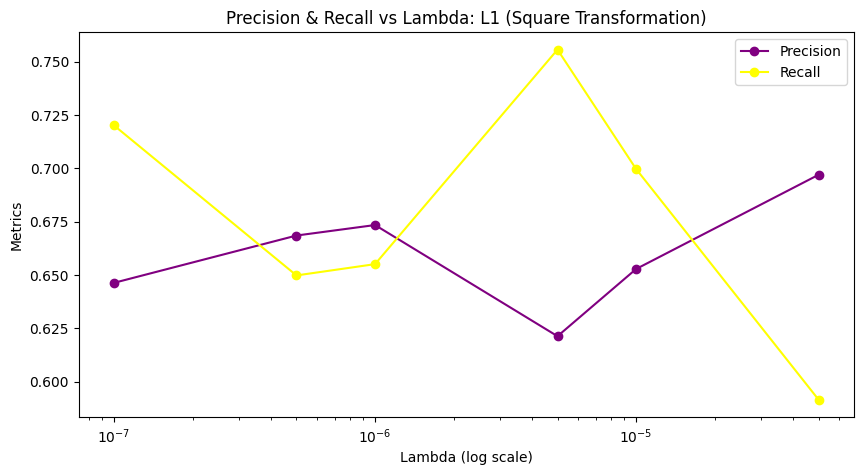

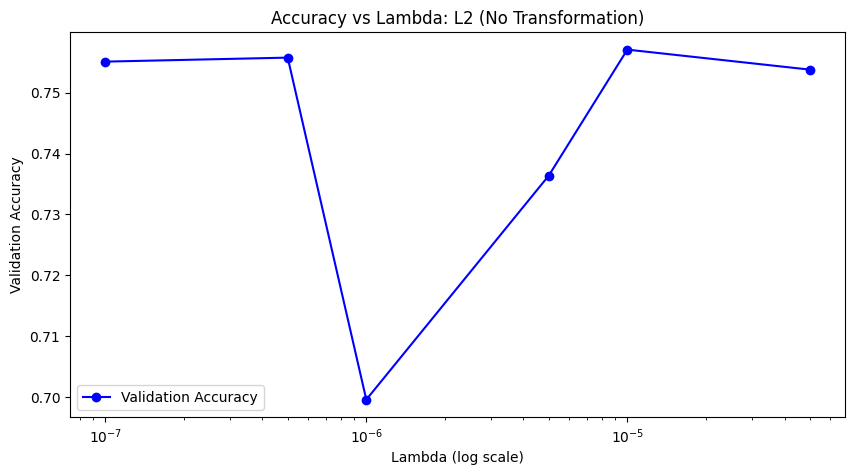

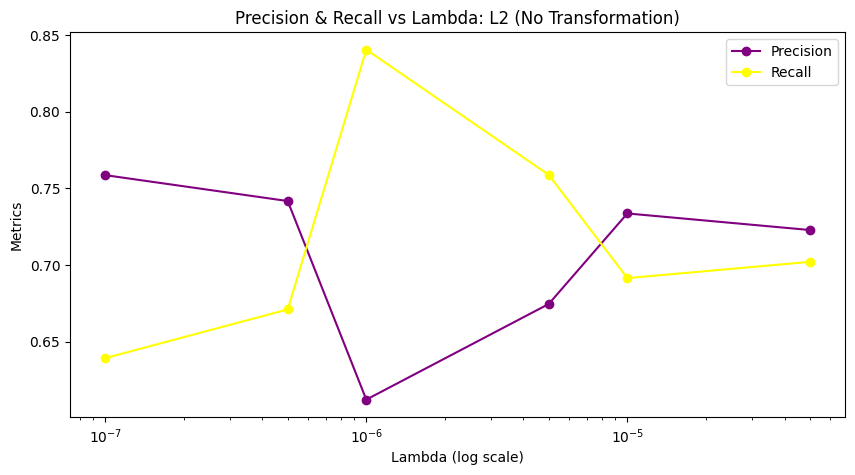

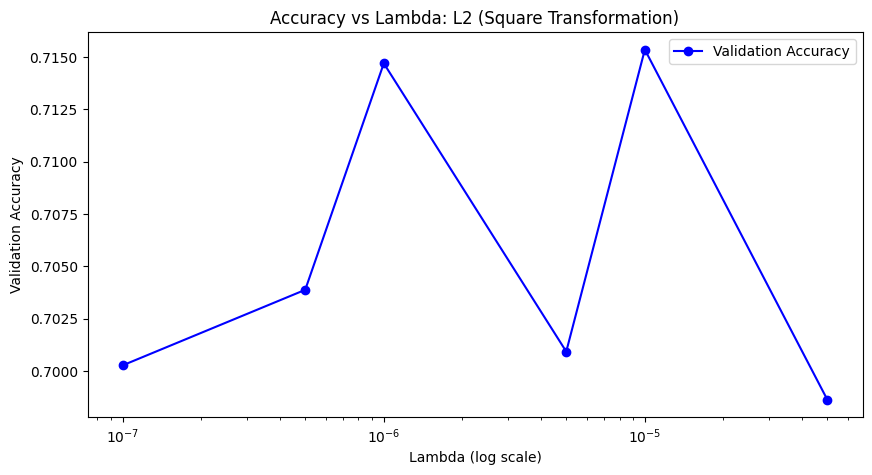

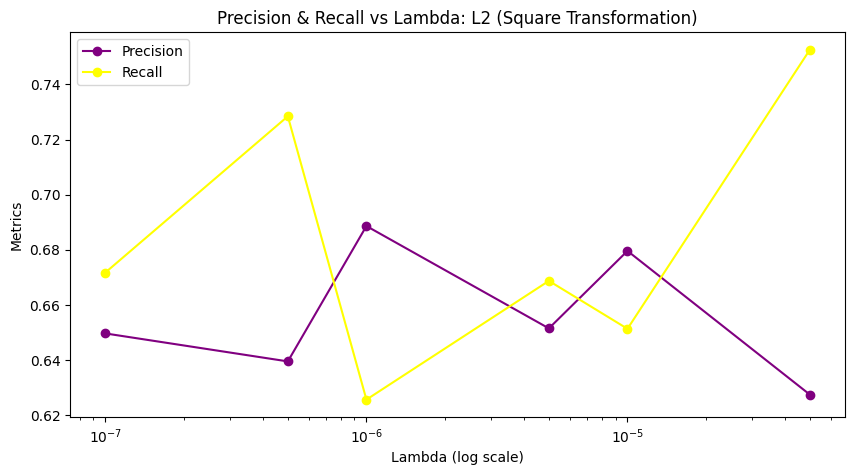

In [18]:

# Plotting the weight sum vs lambda
plt.figure(figsize=(10, 8))
for key, group in results_df.groupby(['regularization', 'transformation']):
    plt.plot(group['lambda'], group['weight_sum'], marker='o', linestyle='-', label=f'{key[0]}, {key[1]}')
plt.title('Sum of Weights vs Lambda')
plt.xlabel('Lambda')
plt.ylabel('Sum of Absolute Weights')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

def plot_combined_metrics(results_df):
    metrics = ['train_accuracy', 'validation_accuracy', 'precision', 'recall']
    transformations = ['none', 'square']
    regularizations = ['L1', 'L2']
    colors = {'train_accuracy': 'red','validation_accuracy': 'blue', 'precision': 'purple', 'recall': 'yellow'}

    for regularization in regularizations:
        for transformation in transformations:
            # Filter DataFrame for specific regularization and transformation
            filtered_df = results_df[(results_df['regularization'] == regularization) & (results_df['transformation'] == transformation)]
            filtered_df = filtered_df.sort_values(by='lambda')  # Sorting may be crucial for logical plotting

            plt.figure(figsize=(10, 5))
            for metric in metrics:
                if metric == 'train_accuracy':
                    plt.plot(filtered_df['lambda'], filtered_df[metric], marker='o', linestyle='-', color=colors[metric], label='Training Accuracy')
                else:
                    plt.plot(filtered_df['lambda'], filtered_df[metric], marker='o', linestyle='-', color=colors[metric], label=metric.replace('_', ' ').capitalize())

            plt.xscale('log')  # Set x-axis to logarithmic scale
            transformation_label = "No Transformation" if transformation == "none" else transformation.capitalize() + " Transformation"
            plt.title(f'Metrics vs Lambda: {regularization} ({transformation_label})')
            plt.xlabel('Lambda (log scale)')
            plt.ylabel('Metric Values')
            plt.legend()
            plt.show()

# Example usage:
plot_combined_metrics(results_df)

def plot_metrics_log_scale(results_df, regularization, transformation):
    # Filter the DataFrame
    filtered_df = results_df[(results_df['regularization'] == regularization) & (results_df['transformation'] == transformation)]
    filtered_df = filtered_df.sort_values(by='lambda')  # Ensure lambda values are sorted

    # Define transformation label
    transformation_label = "No Transformation" if transformation == "none" else transformation.capitalize() + " Transformation"

    # Plotting Validation Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(filtered_df['lambda'], filtered_df['validation_accuracy'], marker='o', linestyle='-', color='blue', label='Validation Accuracy')
    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.title(f'Accuracy vs Lambda: {regularization.upper()} ({transformation_label})')
    plt.xlabel('Lambda (log scale)')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.show()

    # Plotting Precision and Recall
    plt.figure(figsize=(10, 5))
    plt.plot(filtered_df['lambda'], filtered_df['precision'], marker='o', linestyle='-', color='purple', label='Precision')
    plt.plot(filtered_df['lambda'], filtered_df['recall'], marker='o', linestyle='-', color='yellow', label='Recall')
    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.title(f'Precision & Recall vs Lambda: {regularization.upper()} ({transformation_label})')
    plt.xlabel('Lambda (log scale)')
    plt.ylabel('Metrics')
    plt.legend()
    plt.show()

# Example usage:
plot_metrics_log_scale(results_df, 'L1', 'none')
plot_metrics_log_scale(results_df, 'L1', 'square')
plot_metrics_log_scale(results_df, 'L2', 'none')
plot_metrics_log_scale(results_df, 'L2', 'square')

In [ ]:
import pandas as pd

def prepare_and_save_table(df, regularization, transformation, filename):
    # Filter the data for a specific regularization and transformation
    filtered_df = df[(df['regularization'] == regularization) & (df['transformation'] == transformation)]

    # We'll only keep relevant metrics and lambda, dropping other columns
    relevant_df = filtered_df[['lambda', 'train_accuracy', 'validation_accuracy', 'precision', 'recall']]

    # Pivot the table to get lambda values as columns and metrics as rows
    pivoted_df = relevant_df.pivot_table(
        columns='lambda', 
        values=['train_accuracy', 'validation_accuracy', 'precision', 'recall'],
        aggfunc='mean'
    )

    # Reordering the columns to ensure they are sorted by lambda in descending order
    pivoted_df = pivoted_df.reindex(sorted(pivoted_df.columns, reverse=True), axis=1)
    pivoted_df = pivoted_df.round(4)
    pivoted_df.to_csv(filename)

# Example usage for each table:
prepare_and_save_table(results_df, 'L1', 'none', 'L1_none_transformation.csv')
prepare_and_save_table(results_df, 'L1', 'square', 'L1_square_transformation.csv')
prepare_and_save_table(results_df, 'L2', 'none', 'L2_none_transformation.csv')
prepare_and_save_table(results_df, 'L2', 'square', 'L2_square_transformation.csv')

print("Tables saved to CSV files.")


Tables saved to CSV files.
